In [35]:
%load_ext autoreload
import backtrader as bt
import numpy as np
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

%matplotlib inline

plt.rcParams['figure.figsize'] = (20,10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    def notify(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enougth cash
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()


Starting Portfolio Value: 10000.00
2016-01-26, Close, 97.39
2016-01-27, Close, 90.99
2016-01-27, BUY CREATE, 90.99
2016-01-28, BUY EXECUTED, 91.35
2016-01-28, Close, 91.64
2016-01-29, Close, 94.81
2016-02-01, Close, 93.92
2016-02-02, Close, 92.02
2016-02-03, Close, 93.85
2016-02-04, Close, 94.60
2016-02-04, SELL CREATE, 94.60
2016-02-05, SELL EXECUTED, 94.52
2016-02-05, Close, 92.07
2016-02-08, Close, 93.04
2016-02-09, Close, 93.02
2016-02-10, Close, 92.32
2016-02-10, BUY CREATE, 92.32
2016-02-11, BUY EXECUTED, 91.85
2016-02-11, Close, 91.76
2016-02-12, Close, 92.04
2016-02-16, Close, 94.64
2016-02-17, Close, 96.09
2016-02-18, Close, 94.27
2016-02-19, Close, 94.05
2016-02-19, SELL CREATE, 94.05
2016-02-22, SELL EXECUTED, 94.32
2016-02-22, Close, 94.87
2016-02-23, Close, 92.73
2016-02-24, Close, 94.11
2016-02-25, Close, 94.76
2016-02-26, Close, 94.90
2016-02-29, Close, 94.69
2016-03-01, Close, 98.45
2016-03-02, Close, 98.66
2016-03-03, Close, 99.40
2016-03-04, Close, 100.88
2016-03-07, 

/home/ubuntu/venv/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


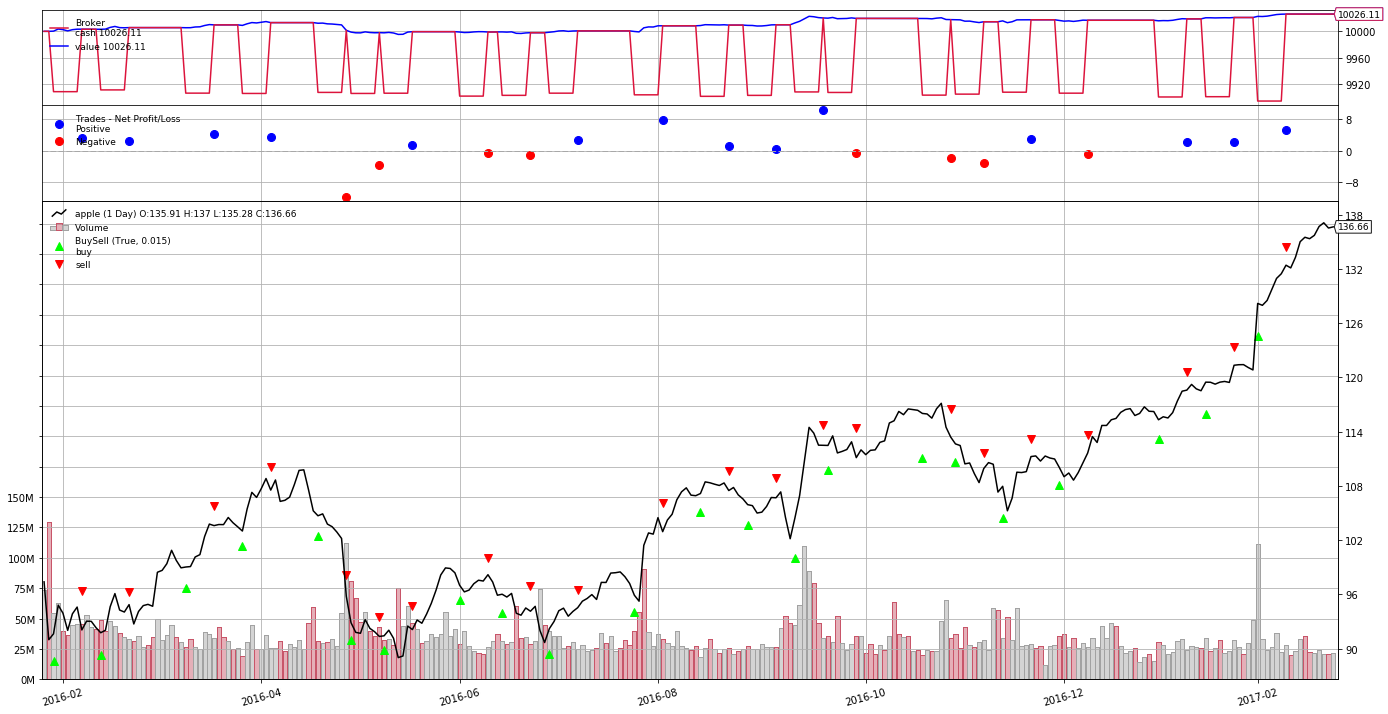

Final Portfolio Value: 10026.11


In [37]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    cerebro.addstrategy(TestStrategy)
    
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, '/home/ubuntu/apple.csv')
    
    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
    dataname=datapath,
    # Do not pass values before this date
    fromdate=datetime.datetime(2000, 1, 1),
    # Do not pass values after this date
    todate=datetime.datetime(2017, 12, 31),
    reverse=True)
    
    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data)
    
    cerebro.broker.setcash(10000.0)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run()
    fig = plt.figure(figsize=(20,10))
    cerebro.plot()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())